In [2]:
import xarray as xr
import numpy as np
import rioxarray  # Import rioxarray for GeoTIFF export
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [6]:
def calculate_percentile(file_path, percentile=98):
    """
    Calculates the specified percentile of daily Min temperature (tasmin) 
    at each grid point in a NetCDF file.
    NOTE: netcdf file of TASMIN has "tasmax_minus_tasmax_minus_tasmin" the variable name
    Args:
        file_path (str): Path to the NetCDF file.
        percentile (int, optional): The percentile to calculate (default: 98).

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the calculated percentile of tasmin for each grid point.
                         Returns None if there's an error.
    """
    try:
        ds = xr.open_dataset(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds['time.month'].isin([6, 7, 8])
    ds_jja = ds.sel(time=jja_mask)
    
    # Calculate the percentile along the time dimension
    percentile_values = ds_jja['tasmax_minus_tasmax_minus_tasmin'].quantile(percentile / 100, dim='time')  # Use quantile directly

    return percentile_values


file_path = "tasmin.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"
percentile_98 = calculate_percentile(file_path, percentile=98)

if percentile_98 is not None:
    print(percentile_98)

    # Save to NetCDF (optional)
    try:
        percentile_98.to_netcdf("VCP_EXHEAT_TMIN_98pct_1950-2014.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

C:\Users\Ben\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B 0.98
NetCDF file created successfully!


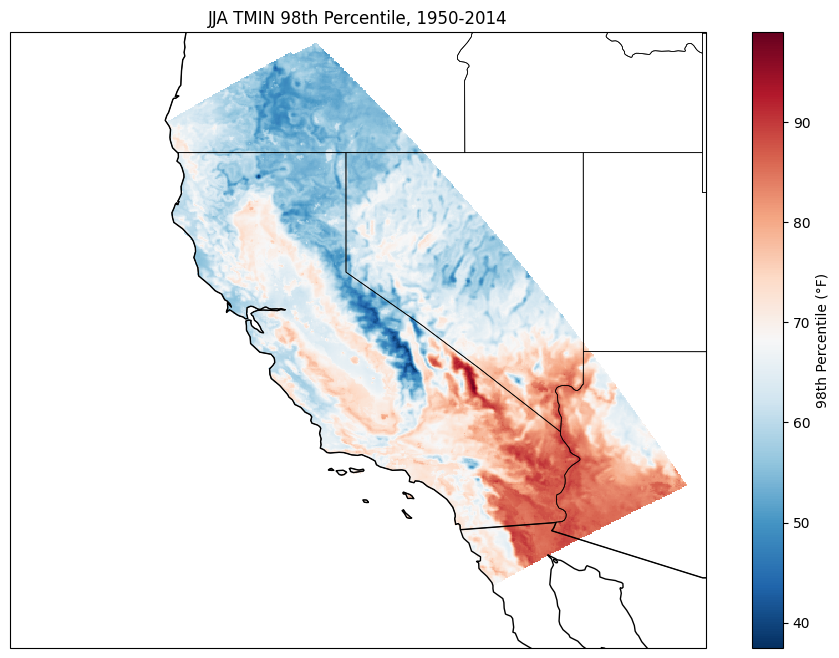

In [7]:
def map_98(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 98th Percentile for TMIN (1950-2014) from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        ds['tasmax_minus_tasmax_minus_tasmin'] = ds['tasmax_minus_tasmax_minus_tasmin'] - 273.15  # Convert Kelvin to Celsius
        ds['tasmax_minus_tasmax_minus_tasmin'] = (ds['tasmax_minus_tasmax_minus_tasmin'] * 9/5) + 32 # Convert Celsius to Fahrenheit
        data = ds[variable_name]
        
        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': '98th Percentile (°F)'})

        plt.title("JJA TMIN 98th Percentile, 1950-2014")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_TMIN_98pct_1950-2014.nc"  # Path to the NetCDF file with the tasmax difference

map_98(netcdf_file_path)

In [10]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmin exceeds the 98th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmin_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time.month'].isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > ds_percentiles['tasmax_minus_tasmax_minus_tasmin']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "tasmin.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_03A_TMIN_98_exceedance_counts_2015-2044.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
NetCDF file created successfully!


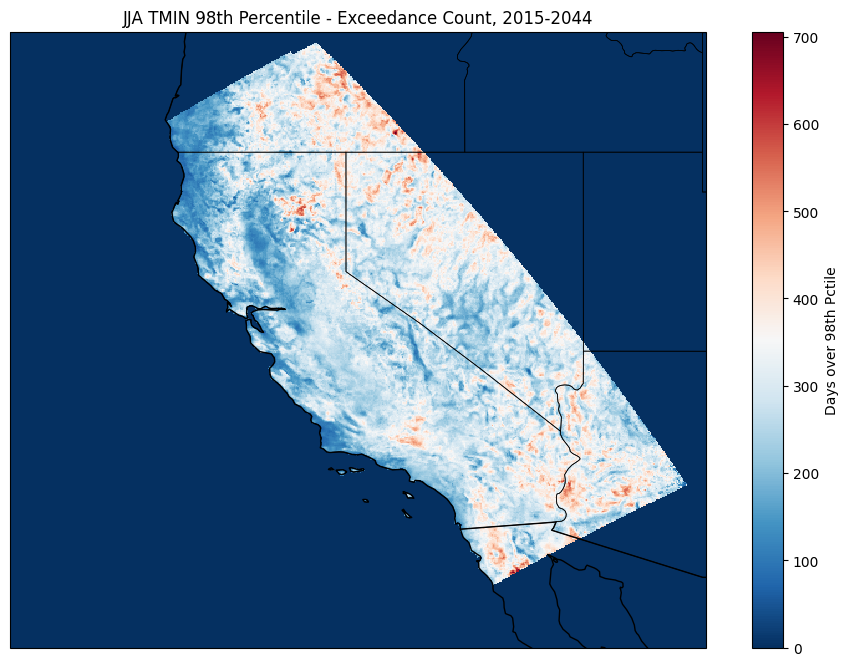

In [12]:
def map_98E(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 98th Pct Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 98th Pctile counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax_minus_tasmax_minus_tasmin".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': 'Days over 98th Pctile'})

        plt.title("JJA TMIN 98th Percentile - Exceedance Count, 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_03A_TMIN_98_exceedance_counts_2015-2044.nc"  # Path to the NetCDF file with the tasmax difference

map_98E(netcdf_file_path)

In [14]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmin exceeds the 98th percentile.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmin_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                         the count of exceedances. Returns None if there's an error.
    """
    try:
      ds_data = xr.open_dataset(file_path_data)
      ds_percentiles = xr.open_dataset(file_path_percentiles)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time.month'].isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Compare daily tasmax with the 98th percentile values.  Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > ds_percentiles['tasmax_minus_tasmax_minus_tasmin']  # Compare DataArrays directly

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear') # Sum over all days in JJA for each year, then sum over all years.

    return exceedance_counts

file_path_data = "tasmin.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_03B_TMIN_98_exceedance_counts_2045-2074.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

<xarray.DataArray 'tasmax_minus_tasmax_minus_tasmin' (lat: 495, lon: 559)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat       (lat) float32 2kB 29.58 29.61 29.64 29.67 ... 44.95 44.98 45.02
  * lon       (lon) float32 2kB 231.6 231.6 231.6 231.7 ... 249.0 249.0 249.0
    quantile  float64 8B ...
NetCDF file created successfully!


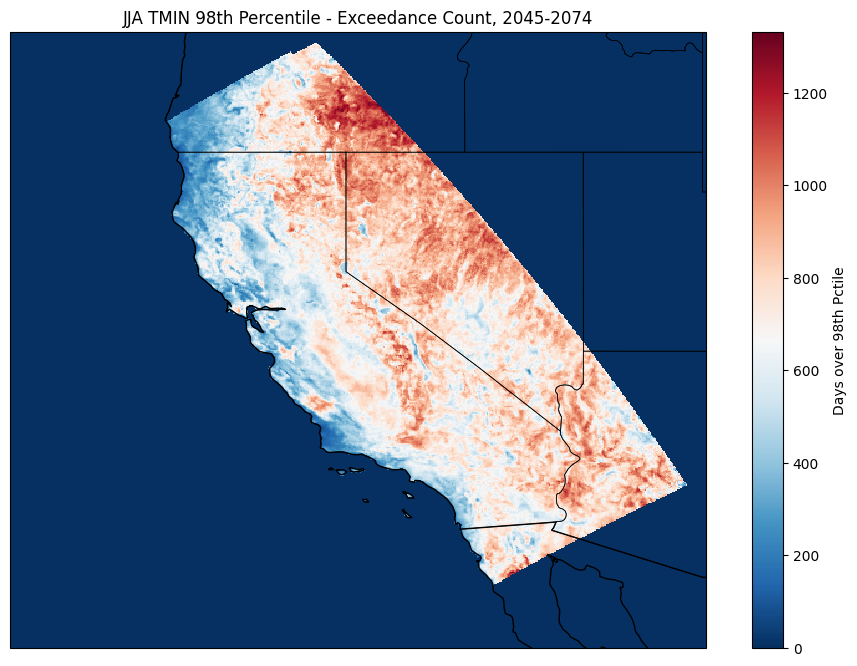

In [18]:
def map_98E(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the 98th Pct Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 98th Pctile counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax_minus_tasmax_minus_tasmin".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': 'Days over 98th Pctile'})

        plt.title("JJA TMIN 98th Percentile - Exceedance Count, 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_03B_TMIN_98_exceedance_counts_2045-2074.nc"  # Path to the NetCDF file with the tasmax difference

map_98E(netcdf_file_path)